In [1]:
cd /Users/marleneguraieb/Downloads/pydata_book_master

/Users/marleneguraieb/Downloads/pydata_book_master


# CHAPTER II

In [2]:
path = 'ch02/usagov_bitly_data2012-03-16-1331923249.txt'

In [3]:
import json

In [4]:
with open(path, encoding='utf-8') as f:
    records=[json.loads(line) for line in f]

records is a list of dictionaries. they're mappings of shit in any order and for any reason. 

In [5]:
time_zones = [rec['tz'] for rec in records if 'tz' in rec]

now time_zones is a list of all the time zones in the list records. you have to add if 'tz' in rec, because not all records have a time zone.

In [6]:
def get_counts(sequence): 
    counts = {} 
    for x in sequence: 
        if x in counts: 
            counts[x] += 1 
        else: counts[x] = 1 
    return counts

let's see what this thing does. counts = {} defines a dictionary. sequence is goung to be a list, so take the first element of the list sequence, if it's in counts, then += means c += a is equivalent to c = c + a. and the way you add keys to a dictionary is dictionary['key']= x, so for x (string for time zone), it's adding one to each time zone if it's there (by changing the definition with the first line), and creating a new entry with value 1 if it's not. 

In [7]:
counts = get_counts(time_zones)

In [8]:
counts['America/New_York']

1251

In [9]:
len(time_zones)

3440

Now we're going to get the top ten time zones and their counts. let's see how: count_dict.items() gives you a list of all the key, value tuples. then somehow the rest of the code flips it around so you can sort by 

In [10]:
def top_counts( count_dict, n = 10): 
    value_key_pairs = [( count, tz) for tz, count in count_dict.items()] 
    value_key_pairs.sort() 
    return value_key_pairs[-n:]

In [11]:
top_counts(counts)

[(33, 'America/Sao_Paulo'),
 (35, 'Europe/Madrid'),
 (36, 'Pacific/Honolulu'),
 (37, 'Asia/Tokyo'),
 (74, 'Europe/London'),
 (191, 'America/Denver'),
 (382, 'America/Los_Angeles'),
 (400, 'America/Chicago'),
 (521, ''),
 (1251, 'America/New_York')]

In [12]:
from collections import Counter

In [13]:
counts = Counter(time_zones)

In [14]:
counts.most_common(10)

[('America/New_York', 1251),
 ('', 521),
 ('America/Chicago', 400),
 ('America/Los_Angeles', 382),
 ('America/Denver', 191),
 ('Europe/London', 74),
 ('Asia/Tokyo', 37),
 ('Pacific/Honolulu', 36),
 ('Europe/Madrid', 35),
 ('America/Sao_Paulo', 33)]

Now we're going to create a dataset with pandas:

In [15]:
from pandas import DataFrame, Series

In [16]:
import pandas as pd

In [17]:
frame = DataFrame(records)

In [18]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3560 entries, 0 to 3559
Data columns (total 18 columns):
_heartbeat_    120 non-null float64
a              3440 non-null object
al             3094 non-null object
c              2919 non-null object
cy             2919 non-null object
g              3440 non-null object
gr             2919 non-null object
h              3440 non-null object
hc             3440 non-null float64
hh             3440 non-null object
kw             93 non-null object
l              3440 non-null object
ll             2919 non-null object
nk             3440 non-null float64
r              3440 non-null object
t              3440 non-null float64
tz             3440 non-null object
u              3440 non-null object
dtypes: float64(4), object(14)
memory usage: 500.7+ KB


In [19]:
frame['tz'][:10]

0     America/New_York
1       America/Denver
2     America/New_York
3    America/Sao_Paulo
4     America/New_York
5     America/New_York
6        Europe/Warsaw
7                     
8                     
9                     
Name: tz, dtype: object

In [20]:
tz_counts = frame['tz'].value_counts()

In [21]:
tz_counts[:10]

America/New_York       1251
                        521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Europe/London            74
Asia/Tokyo               37
Pacific/Honolulu         36
Europe/Madrid            35
America/Sao_Paulo        33
Name: tz, dtype: int64

In [22]:
clean_tz = frame['tz'].fillna('Missing')

In [23]:
clean_tz[clean_tz=='']='Unknown'

In [24]:
tz_counts = clean_tz.value_counts()

In [25]:
tz_counts[:10]

America/New_York       1251
Unknown                 521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Missing                 120
Europe/London            74
Asia/Tokyo               37
Pacific/Honolulu         36
Europe/Madrid            35
Name: tz, dtype: int64

In [26]:
%matplotlib inline

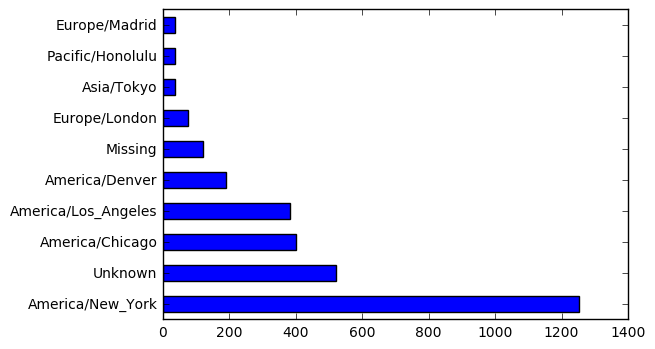

In [27]:
tz_counts[:10].plot(kind='barh',rot=0)

Next trick, how the hell do we parse information that looks like this:

In [28]:
frame['a'][0]

'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/535.11 (KHTML, like Gecko) Chrome/17.0.963.78 Safari/535.11'

notice that frame.a.dropna() gives you the column a of frame without the missing values!! Series is a panda function that gives you a one dimensional array with an index (basically a one column dataframe). split() gives you a list of elements where it separates on each argument, split() no argument separates on space. subsetting [0] gives you the first element of that list.  

In [29]:
results = pd.Series([ x.split()[ 0] for x in frame.a.dropna()])

In [30]:
results.value_counts()[:8]

Mozilla/5.0                 2594
Mozilla/4.0                  601
GoogleMaps/RochesterNY       121
Opera/9.80                    34
TEST_INTERNET_AGENT           24
GoogleProducer                21
Mozilla/6.0                    5
BlackBerry8520/5.0.0.681       4
dtype: int64

In [31]:
cframe = frame[frame.a.notnull()]

In [33]:
import numpy as np

In [34]:
operating_system = np.where(cframe['a'].str.contains('Windows'),'Windows','Not Windows')

In [35]:
by_tz_os = cframe.groupby(['tz',operating_system])

by_tz_os.size() gives us the table that we want (counts values by tz, and divides in whether they're windows or not windows). unstack puts them in two columns (instead of stacked) and fillna gives you zeroes when they're nas. 

In [36]:
agg_counts = by_tz_os.size().unstack().fillna(0)

In [41]:
indexer = agg_counts.sum(1).argsort()

In [48]:
indexer=agg_counts.sum(1).argsort()

In [50]:
count_subset = agg_counts.take(indexer)[-10:]

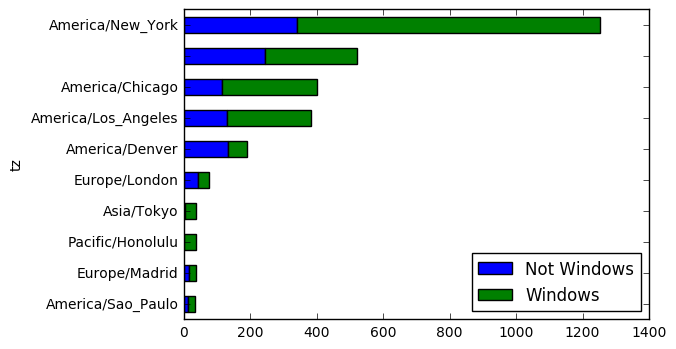

In [52]:
count_subset.plot(kind='barh',stacked=True)

In [53]:
#normalize and sum to one
normed_subset = count_subset.div(count_subset.sum(1),axis=0)

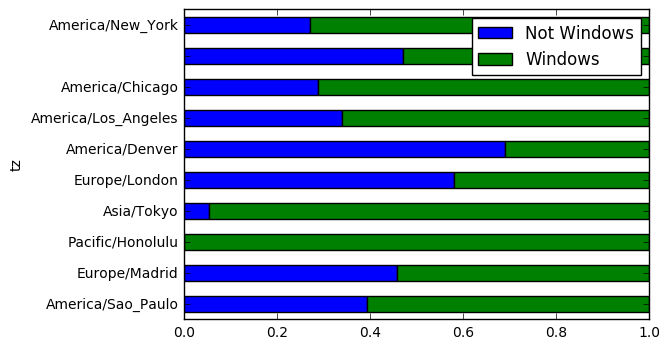

In [54]:
normed_subset.plot(kind='barh',stacked=True)

# Chapter II: dataset movieLens

In [130]:
#this lets you look at data without even opening the thing! 
#This is how you get the column names!
!head -n 10 ch02/movielens/movies.dat

1::Toy Story (1995)::Animation|Children's|Comedy
2::Jumanji (1995)::Adventure|Children's|Fantasy
3::Grumpier Old Men (1995)::Comedy|Romance
4::Waiting to Exhale (1995)::Comedy|Drama
5::Father of the Bride Part II (1995)::Comedy
6::Heat (1995)::Action|Crime|Thriller
7::Sabrina (1995)::Comedy|Romance
8::Tom and Huck (1995)::Adventure|Children's
9::Sudden Death (1995)::Action
10::GoldenEye (1995)::Action|Adventure|Thriller


In [61]:
import os

In [62]:
cwd = os.getcwd()

In [63]:
cwd

'/Users/marleneguraieb/Downloads/pydata_book_master'

In [55]:
import pandas as pd

The MovieLens 1M data set contains 1 million ratings collected from 6000 users on 4000 movies. It’s spread across 3 tables: ratings, user information, and movie information.

In [57]:
unames = ['user_id','gender','age','occupation','zip']

In [84]:
users = pd.read_table('ch02/movielens/users.dat',sep='::',
                      header=None,names=unames,engine='python')

In [70]:
rnames = ['user_id','movie_id','rating','timestamp']

In [86]:
ratings = pd.read_table('ch02/movielens/ratings.dat',sep='::',
                        header=None,names=rnames,engine='python')

In [73]:
mnames = ['movie_id','title','genres']

In [89]:
movies = pd.read_table('ch02/movielens/movies.dat',sep='::',
                      header=None,names=mnames, 
                      engine='python')

In [95]:
data = pd.merge(pd.merge(ratings,users),movies)

In [99]:
mean_ratings = data.pivot_table('rating',index='title',
                                columns='gender',aggfunc='mean')

In [101]:
ratings_by_title = data.groupby('title').size()

In [103]:
active_titles = ratings_by_title.index[ratings_by_title>=250]

In [107]:
mean_ratings = mean_ratings.ix[active_titles]

In [112]:
top_female_ratings = mean_ratings.sort_values(by='F',ascending=False)

In [114]:
mean_ratings['diff']= mean_ratings['M']-mean_ratings['F']

In [115]:
sorted_by_diff = mean_ratings.sort_values(by='diff')

In [118]:
#[::-1] reverses the order of rows!
sorted_by_diff[::-1][:2]

gender,F,M,diff
title,,,
"Good, The Bad and The Ugly, The (1966)",3.494949,4.221300,0.726351
"Kentucky Fried Movie, The (1977)",2.878788,3.555147,0.676359


In [119]:
rating_std_by_title = data.groupby('title')['rating'].std()

In [120]:
rating_std_by_title = rating_std_by_title.ix[active_titles]

In [122]:
rating_std_by_title.sort_values(ascending=False)[:10]

title
Dumb & Dumber (1994)                     1.321333
Blair Witch Project, The (1999)          1.316368
Natural Born Killers (1994)              1.307198
Tank Girl (1995)                         1.277695
Rocky Horror Picture Show, The (1975)    1.260177
Eyes Wide Shut (1999)                    1.259624
Evita (1996)                             1.253631
Billy Madison (1995)                     1.249970
Fear and Loathing in Las Vegas (1998)    1.246408
Bicentennial Man (1999)                  1.245533
Name: rating, dtype: float64

## Chapter II baby name database 

In [131]:
names1880 = pd.read_csv('ch02/names/yob1880.txt', 
                        names=['name','sex','births'])

This is to merge all files by year from different databases:

In [135]:
pieces = []
columns = ['name','sex','births']
years = range(1880,2011)

In [136]:
for year in years:
    path = 'ch02/names/yob%d.txt' % year
    frame = pd.read_csv(path, names=columns)
    
    frame['year'] = year
    pieces.append(frame)

In [139]:
names = pd.concat(pieces, ignore_index=True)

In [145]:
total_births = names.pivot_table('births',index='year',columns='sex',
                                aggfunc=sum)

In [147]:
total_births.tail()

sex,F,M
year,,
2006,1896468,2050234
2007,1916888,2069242
2008,1883645,2032310
2009,1827643,1973359
2010,1759010,1898382


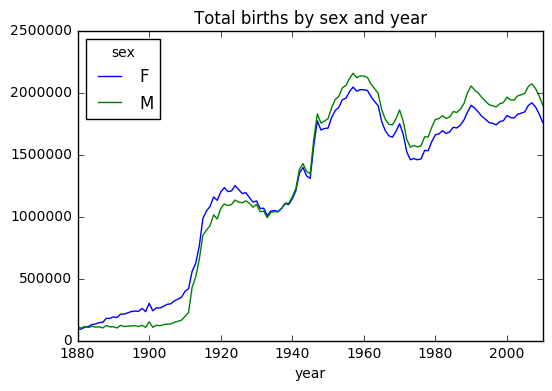

In [148]:
total_births.plot(title='Total births by sex and year')

In [149]:
def add_prop(group):
    #Integer division floors
    births = group.births.astype(float)
    group['prop'] = births/births.sum()
    return group

In [150]:
names = names.groupby(['year','sex']).apply(add_prop)

In [152]:
np.allclose(names.groupby(['year','sex']).prop.sum(),1)

True

In [164]:
def get_top1000( group): 
    return group.sort_values( by ='births', 
    ascending = False)[: 1000] 

In [166]:
grouped = names.groupby(['year', 'sex'])
top1000 = grouped.apply(get_top1000)
top1000.index = np.arange(len(top1000))

In [172]:
boys = top1000[top1000.sex=='M']
girls = top1000[top1000.sex=='F']

In [175]:
total_births = top1000.pivot_table('births',index='year',
                                   columns='name',
                                  aggfunc=sum)

In [177]:
subset = total_births[['John','Harry','Mary','Marilyn']]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11e1b9c18>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x120c4e748>], dtype=object)

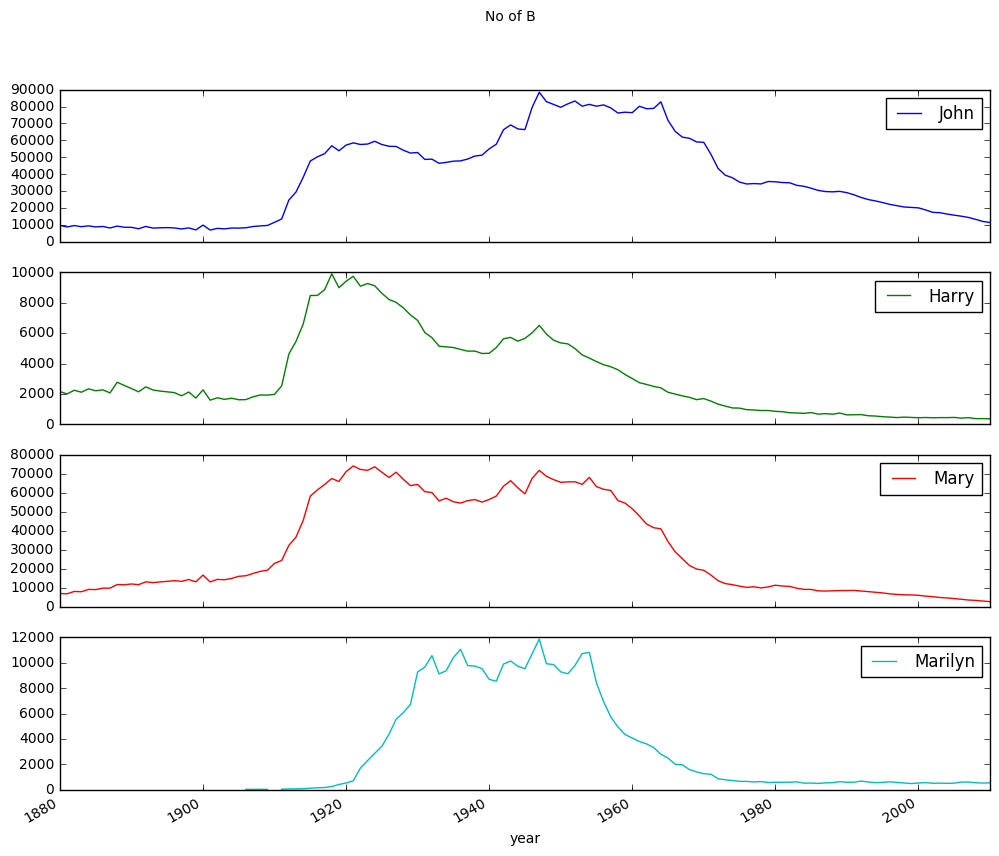

In [178]:
subset.plot(subplots=True,figsize=(12,10),grid=False,title="No of B")

In [179]:
table = top1000.pivot_table('prop',index='year',columns='sex',
                           aggfunc=sum)

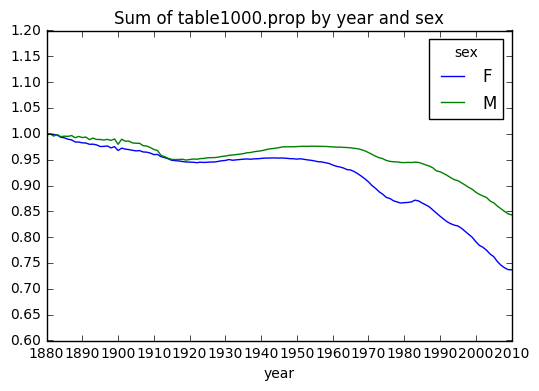

In [182]:
table.plot(title='Sum of table1000.prop by year and sex', 
           yticks=np.linspace(0.6,1.2,13),xticks=range(1880,2020,10))

In [183]:
df = boys[boys.year == 2010]

In [186]:
prop_cumsum = df.sort_values(by ='prop', 
              ascending = False).prop.cumsum() 

In [187]:
prop_cumsum[:10]

260877    0.011523
260878    0.020934
260879    0.029959
260880    0.038930
260881    0.047817
260882    0.056579
260883    0.065155
260884    0.073414
260885    0.081528
260886    0.089621
Name: prop, dtype: float64

Last letter revolution: extract last letter from name: lambda is an empty function, it's awesome, read more about this: 

In [197]:
get_last_letter = lambda x: x[-1] 
last_letters = names.name.map(get_last_letter) 
last_letters.name = 'last_letter' 
table = names.pivot_table('births', 
                          index = last_letters, 
                          columns =['sex', 'year'],
                          aggfunc = sum)

In [198]:
subtable = table.reindex(columns =[ 1910, 1960, 2010], 
                         level ='year') 

In [199]:
subtable.head()

sex                 F                            M                    
year             1910      1960      2010     1910      1960      2010
last_letter                                                           
a            108376.0  691247.0  670605.0    977.0    5204.0   28438.0
b                 NaN     694.0     450.0    411.0    3912.0   38859.0
c                 5.0      49.0     946.0    482.0   15476.0   23125.0
d              6750.0    3729.0    2607.0  22111.0  262112.0   44398.0
e            133569.0  435013.0  313833.0  28655.0  178823.0  129012.0

In [200]:
subtable.sum()

sex  year
F    1910     396416.0
     1960    2022062.0
     2010    1759010.0
M    1910     194198.0
     1960    2132588.0
     2010    1898382.0
dtype: float64

In [202]:
import matplotlib.pyplot as plt

In [206]:
letter_prop = subtable/subtable.sum().astype(float) 

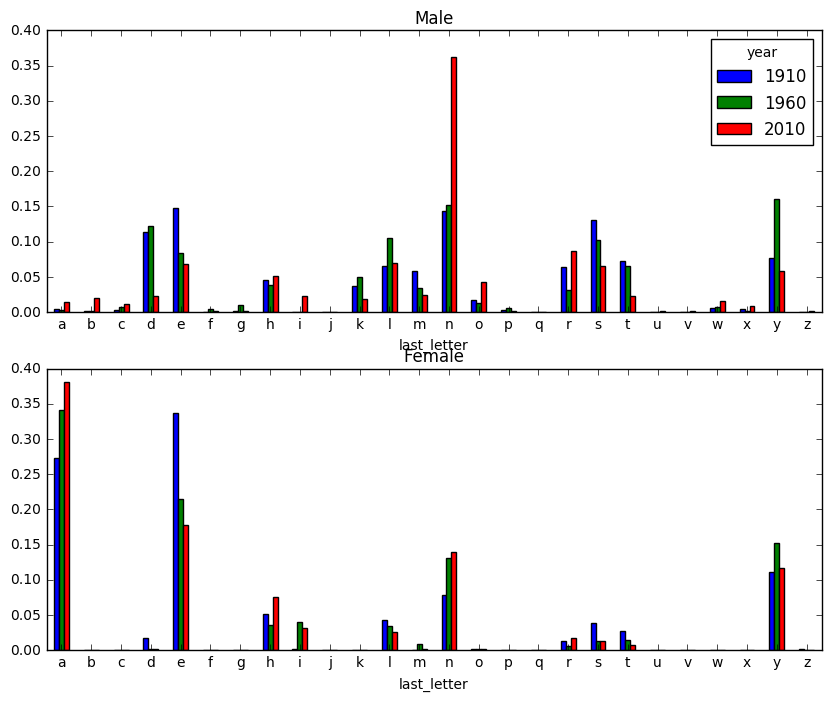

In [207]:
fig, axes = plt.subplots( 2, 1, figsize =( 10, 8)) 
letter_prop['M'].plot(kind ='bar', rot = 0, 
                     ax = axes[0], title ='Male') 
letter_prop['F'].plot(kind ='bar', rot = 0, 
                      ax = axes[1], title ='Female', 
                      legend = False)

# Chapter 4: NumPy

In [1]:
import numpy as np

In [4]:
data = np.array([[0.9526,-0.24,-0.88],[0.56,0.23,0.91]])

In [15]:
np.zeros(10)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [17]:
np.zeros((3,6))

array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])

In [18]:
#this doesn't work!
np.empty(((2,3,2)))

array([[[  0.00000000e+000,  -1.32781403e-315],
        [  2.20281399e-314,   2.20285099e-314],
        [  2.20284106e-314,   2.20285096e-314]],

       [[  2.55088945e+217,   0.00000000e+000],
        [  2.14369536e-314,   6.36598737e-311],
        [  0.00000000e+000,   8.34402830e-309]]])

In [21]:
arr1 = np.array([ 1, 2, 3], dtype = np.float64) 
arr2 = np.array([ 1, 2, 3], dtype = np.int32)

In [23]:
arr1.dtype,arr2.dtype

(dtype('float64'), dtype('int32'))

In [30]:
arr = np.arange(5)+1

In [32]:
float_arr = arr.astype(np.float64)

In [33]:
float_arr.dtype

dtype('float64')

In [34]:
#broadcasting is operations on arrays of different sizes. array slices are views on the original array. this means that 
# the data is not copied, and any modifications on the view will be reflected in the source array

In [35]:
arr = np.arange(10)

In [36]:
arr_slice = arr[5:8]

In [37]:
arr_slice[1] = 12345

In [38]:
arr

array([    0,     1,     2,     3,     4,     5, 12345,     7,     8,     9])

In [39]:
arr_slice[:] = 64

In [40]:
arr

array([ 0,  1,  2,  3,  4, 64, 64, 64,  8,  9])

In [ ]:
#this is because numpy wants to save memory, so it doesn't automatically copy arrays, they're called views
#if you want a copy you can use the .copy() method as in:

In [42]:
arr[5:8].copy()

array([64, 64, 64])

In [ ]:
# left this chapter, too abstract. maybe come back to it later if you need it but for now it's fine. 

# Chapter V: pandas

In [43]:
import pandas as pd

In [ ]:
#pandas has two basic data structures: series and dataframes
# a series is a one dimensional array-like object containing an array of data of any type and an associated 
#array of labels called its index. simples series is formed from only an array of data

## Series

In [45]:
obj = pd.Series([4,7,-5,3])

In [46]:
obj

0    4
1    7
2   -5
3    3
dtype: int64

In [47]:
# since we did not specify an index for the data, a default one consisting of the integers 0 through N is given.

In [56]:
obj.values

array([ 4,  7, -5,  3])

In [57]:
obj.index

RangeIndex(start=0, stop=4, step=1)

In [59]:
obj2 = pd.Series([4,7,-5,3], index = ['d','b','a','c'])

In [60]:
obj2

d    4
b    7
a   -5
c    3
dtype: int64

In [ ]:
#you can use the values to subset:

In [62]:
obj2[['a','c']]

a   -5
c    3
dtype: int64

In [ ]:
#operations will preserve the index-value link:

In [63]:
obj2[obj2 > 0]

d    4
b    7
c    3
dtype: int64

In [64]:
obj2*2

d     8
b    14
a   -10
c     6
dtype: int64

In [65]:
np.exp(obj2)

d      54.598150
b    1096.633158
a       0.006738
c      20.085537
dtype: float64

In [66]:
#another way to think about a series is a fixed-length ordered dict, as it is a mapping of index values to data values.
# it can be substituted into many functions that expect a dict:

In [67]:
'b' in obj2

True

In [ ]:
#if you have a dict, you can create a series from the dict

In [68]:
sdata = {'Ohio':35000,'Texas':71000,'Oregon':16000,'Utah':5000}

In [69]:
obj3 = pd.Series(sdata)

In [70]:
obj3

Ohio      35000
Oregon    16000
Texas     71000
Utah       5000
dtype: int64

In [72]:
states = ['California', 'Ohio', 'Oregon', 'Texas'] 
obj4 = pd.Series( sdata, index = states)

In [73]:
obj4

California        NaN
Ohio          35000.0
Oregon        16000.0
Texas         71000.0
dtype: float64

In [74]:
pd.isnull(obj4)

California     True
Ohio          False
Oregon        False
Texas         False
dtype: bool

In [75]:
obj4.isnull()

California     True
Ohio          False
Oregon        False
Texas         False
dtype: bool

In [77]:
obj3+obj4

California         NaN
Ohio           70000.0
Oregon         32000.0
Texas         142000.0
Utah               NaN
dtype: float64

In [78]:
obj4.name = 'population'
obj4.index.name = 'state'

In [79]:
obj4

state
California        NaN
Ohio          35000.0
Oregon        16000.0
Texas         71000.0
Name: population, dtype: float64

In [80]:
obj.index = ['Bob','Steve','Jeff','Ryan']

In [81]:
obj

Bob      4
Steve    7
Jeff    -5
Ryan     3
dtype: int64

## DATAFRAMES

In [ ]:
# you can create a dataframe from a dict of equal length arrays (yes you can map a thing to a list here!)

In [87]:
data = {'state': ['Ohio', 'Ohio', 'Ohio', 'Nevada', 'Nevada'], 
        'year': [2000, 2001, 2002, 2001, 2002], 
        'pop': [1.5, 1.7, 3.6, 2.4, 2.9]} 
frame = pd.DataFrame( data)

In [88]:
frame

,pop,state,year
0,1.5,Ohio,2000
1,1.7,Ohio,2001
2,3.6,Ohio,2002
3,2.4,Nevada,2001
4,2.9,Nevada,2002


In [91]:
frame2 = pd.DataFrame(data, columns=['year','state','pop','debt'], index =['one','two','three','four','five'])

In [92]:
frame2.columns

Index(['year', 'state', 'pop', 'debt'], dtype='object')

In [93]:
frame2['state']

one        Ohio
two        Ohio
three      Ohio
four     Nevada
five     Nevada
Name: state, dtype: object

In [94]:
frame2.year

one      2000
two      2001
three    2002
four     2001
five     2002
Name: year, dtype: int64

In [95]:
frame2.ix['three']

year     2002
state    Ohio
pop       3.6
debt      NaN
Name: three, dtype: object

In [100]:
frame2['debt']= np.arange(5.)

In [101]:
frame2

,year,state,pop,debt
one,2000,Ohio,1.5,0.0
two,2001,Ohio,1.7,1.0
three,2002,Ohio,3.6,2.0
four,2001,Nevada,2.4,3.0
five,2002,Nevada,2.9,4.0


In [103]:
val = pd.Series([-1.2,-1.5,-1.7], index=['two','four','five'])

In [104]:
frame2['debt']= val

In [105]:
frame2

,year,state,pop,debt
one,2000,Ohio,1.5,NaN
two,2001,Ohio,1.7,-1.2
three,2002,Ohio,3.6,NaN
four,2001,Nevada,2.4,-1.5
five,2002,Nevada,2.9,-1.7


In [107]:
frame2['eastern'] = frame2.state=='Ohio'

In [108]:
del frame2['eastern']

In [109]:
frame2.columns

Index(['year', 'state', 'pop', 'debt'], dtype='object')

In [ ]:
#this is a nested dict of dicts, it can also become a dataframe:

In [110]:
pop = {'Nevada':{2001:2.4,2002:2.9}, 
       'Ohio':{2000:1.5,2001:1.7,2002:3.6}}

In [114]:
frame3 = pd.DataFrame(pop)

In [116]:
frame3.T

,2000,2001,2002
Nevada,NaN,2.4,2.9
Ohio,1.5,1.7,3.6


In [118]:
frame3

,Nevada,Ohio
2000,NaN,1.5
2001,2.4,1.7
2002,2.9,3.6


In [119]:
frame3.index.name = 'year'
frame3.columns.name = 'state'

In [125]:
obj = pd.Series(range(3), index=['a','b','c'])

In [126]:
index = obj.index

In [127]:
index[1:]

Index(['b', 'c'], dtype='object')

In [129]:
index = pd.Index(np.arange(3))

In [130]:
obj2.index is index

False

In [131]:
obj2

d    4
b    7
a   -5
c    3
dtype: int64

In [ ]:
#location 2789